In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

sns.set_style("white")

In [27]:
mlrun_dir = "/home/kevin/qbic/mlf_core_project/mlruns"
name_id_mapping = {'gpu_non_deterministic': '1', 'gpu_random': '2', 'cpu_random': '3',
                   'gpu_deterministic': '4'}

## Make the data table

In [28]:
keys = name_id_mapping.keys()
dfs = {}
for k in keys:
    experiment_path = os.path.join(mlrun_dir, name_id_mapping[k])
    runs = os.listdir(experiment_path)
    runs = [x for x in runs if not x == 'meta.yaml'] # remove yaml file from runs
    
    df_list = []
    for i in range(len(runs)):
        run = runs[i]
        loss = pd.read_csv(os.path.join(experiment_path, run, "metrics/loss"), sep=" ", header=None)
        loss.columns = ['id', 'loss', 'epoch']
        loss['run'] = ['run' + str(i)] * loss.shape[0]
        df_list.append(loss)
    df = pd.concat(df_list)
    dfs[k] = df
    

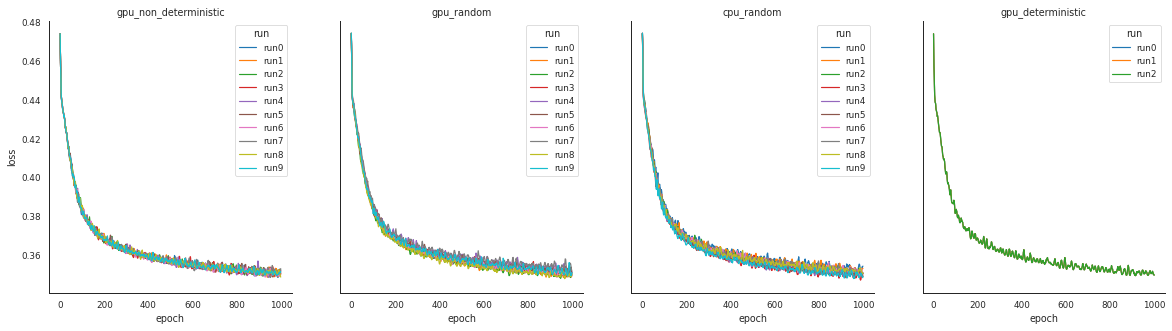

In [29]:

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, key in enumerate(dfs.keys()):    
    sns.lineplot(ax=axes[i], x='epoch', y='loss', hue='run', data=dfs[key])
    axes[i].set_title(key)
    sns.despine()
plt.savefig("plots/loss_per_epoch.png")
plt.show()

In [30]:
df.head(n=10)

,id,loss,epoch,run
0,1607615874734,0.473940,0,run0
1,1607615874863,0.464680,1,run0
2,1607615874997,0.456907,2,run0
3,1607615875129,0.452665,3,run0
4,1607615875259,0.446130,4,run0
5,1607615875388,0.442443,5,run0
6,1607615875514,0.440292,6,run0
7,1607615875637,0.439031,7,run0
8,1607615875772,0.438435,8,run0
9,1607615875896,0.438215,9,run0


## Standard deviation of losses

In [31]:
# Calculate standard deviation and make plots
std_list = []
keys = dfs.keys()

for k in keys:
    print(k)
    tmp = dfs[k]
    
    epoch_stds = []
    # calculate the stds per epoch
    for i in range(1000):
        epoch = tmp[tmp['epoch'] == i]
        epoch_stds.append(np.std(epoch['loss']))
    
    std_list.append(epoch_stds)

std_df = pd.DataFrame(std_list).T
std_df.columns = keys
std_df = pd.melt(std_df)

gpu_non_deterministic
gpu_random
cpu_random
gpu_deterministic


In [32]:
std_df.head()

,variable,value
0,gpu_non_deterministic,5.551115e-17
1,gpu_non_deterministic,5.551115e-17
2,gpu_non_deterministic,5.551115e-17
3,gpu_non_deterministic,2.920019e-08
4,gpu_non_deterministic,5.161914e-08


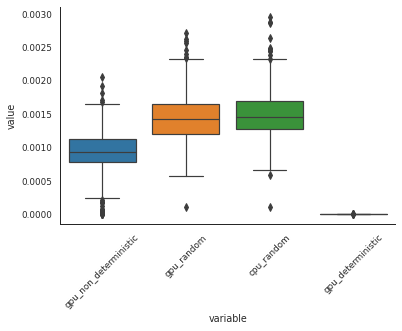

In [33]:
sns.set_style("white")
sns.set_context("paper")
ax = sns.boxplot(x = 'variable', y='value', data=std_df, )
ax.set_xticklabels(rotation = 45, labels = keys)
sns.despine()
plt.savefig("plots/std_boxplots.png")

# Just the losses

In [34]:
# Calculate standard deviation and make plots
loss_list = []
keys = dfs.keys()

for k in keys:
    print(k)
    tmp = dfs[k]
    
    losses = tmp[tmp['epoch'] == 999].copy()
    losses.drop(columns=['id', 'epoch', 'run'], axis=2, inplace=True)
    losses['experiment'] = [k]*losses.shape[0]
    loss_list.append(losses)
    

loss_df = pd.concat(loss_list)

gpu_non_deterministic
gpu_random
cpu_random
gpu_deterministic


In [35]:
# Make experiment names more pretty
experiment_names = list(loss_df['experiment'])
experiment_names = [x.replace("gpu_non_deterministic", "Non-deterministic GPU") for x in experiment_names]
experiment_names = [x.replace("gpu_random", "Random-seed GPU") for x in experiment_names]
experiment_names = [x.replace("cpu_random", "Random-seed CPU") for x in experiment_names]
experiment_names = [x.replace("gpu_deterministic", "Deterministic GPU") for x in experiment_names]
loss_df['experiment'] = experiment_names
labels = ["Non-deterministic GPU", "Random-seed GPU", "Random-seed CPU", "Deterministic GPU"]

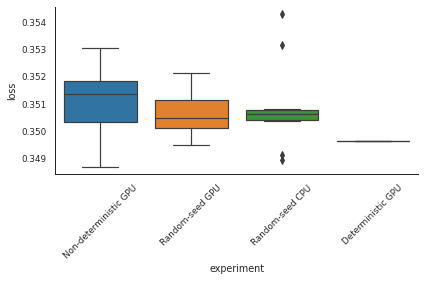

In [36]:
sns.set_style("white")
sns.set_context("paper")
ax = sns.boxplot(x = 'experiment', y='loss', data=loss_df, )
ax.set_xticklabels(rotation = 45, labels = labels)
sns.despine()
plt.tight_layout()
plt.savefig("plots/loss_boxplots.png")

In [19]:
loss_df.head(n=10)

,loss,experiment
999,0.350307,gpu_non_deterministic
999,0.349865,gpu_non_deterministic
999,0.352419,gpu_non_deterministic
999,0.350414,gpu_non_deterministic
999,0.351505,gpu_non_deterministic
999,0.351819,gpu_non_deterministic
999,0.351854,gpu_non_deterministic
999,0.353037,gpu_non_deterministic
999,0.348672,gpu_non_deterministic
999,0.351203,gpu_non_deterministic


## Change of STD over time

In [24]:
std_df = pd.DataFrame(std_list).T
std_df.columns = keys
std_df['epoch'] = list(std_df.index)
std_df = pd.melt(std_df, id_vars='epoch')
std_df.head()

,epoch,variable,value
0,0,gpu_non_deterministic,5.551115e-17
1,1,gpu_non_deterministic,5.551115e-17
2,2,gpu_non_deterministic,5.551115e-17
3,3,gpu_non_deterministic,2.920019e-08
4,4,gpu_non_deterministic,5.161914e-08


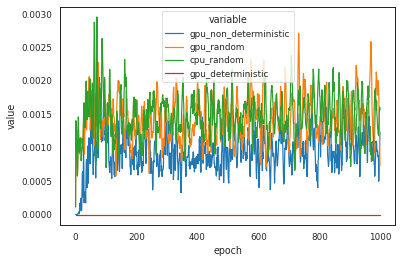

In [25]:
#sns.set(rc={'figure.figsize':(15,9)})
sns.set_style("white")
sns.set_context("paper")
ax = sns.lineplot(x='epoch', y='value', hue='variable', data=std_df, ci="sd")
plt.savefig("plots/std_per_epoch_lineplot.png")